In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder,MinMaxScaler
from sklearn.metrics import accuracy_score
import sys
sys.path.append('../..') 
import evaluation
sys.path.append('../') 
import utils
import utils2
from imblearn.over_sampling import SMOTE
from fastcore.basics import Path, AttrDict
import matplotlib.pyplot as plt

In [4]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [5]:
config = AttrDict(
    challenge_data_dir = Path('D:/SPLID/splid-devkit/data').expanduser(),
    valid_ratio = 0.1,
    lag_steps = 5
)

In [6]:
# Define the list of feature columns
feature_cols = [
    "Eccentricity",
    "Semimajor Axis (m)",
    "Inclination (deg)",
    "RAAN (deg)",
    "Argument of Periapsis (deg)",
    "True Anomaly (deg)",
    "Latitude (deg)",
    "Longitude (deg)",
    "Altitude (m)",
    "X (m)",
    "Y (m)",
    "Z (m)",
    "Vx (m/s)",
    "Vy (m/s)",
    "Vz (m/s)"
]

In [7]:
# Define the directory paths
train_data_dir = config.challenge_data_dir / "train"

# Load the ground truth data
ground_truth = pd.read_csv(config.challenge_data_dir / 'train_labels.csv')

# Apply the function to the ground truth data
data, updated_feature_cols = utils.tabularize_data(train_data_dir, feature_cols, 
                                          ground_truth, lag_steps=config.lag_steps)

# For each ObjectID, show the first rows of the columns TimeIndex, ObjectID, EW, and NS
data[['ObjectID', 'TimeIndex' , 'EW', 'NS']].groupby('ObjectID').head(2).head(10)

,ObjectID,TimeIndex,EW,NS
0,1,0,SS-HK,SS-HK
1,1,1,SS-HK,SS-HK
0,10,0,SS-CK,SS-NK
1,10,1,SS-CK,SS-NK
0,100,0,SS-CK,SS-CK
1,100,1,SS-CK,SS-CK
0,101,0,SS-CK,SS-NK
1,101,1,SS-CK,SS-NK
0,102,0,SS-CK,SS-NK
1,102,1,SS-CK,SS-NK


In [8]:
# Create a validation set without mixing the ObjectIDs
object_ids = data['ObjectID'].unique()
train_ids, valid_ids = train_test_split(object_ids,
                                        test_size=config.valid_ratio, 
                                        random_state=42)

train_data = data[data['ObjectID'].isin(train_ids)].copy()
valid_data = data[data['ObjectID'].isin(valid_ids)].copy()

ground_truth_train = ground_truth[ground_truth['ObjectID'].isin(train_ids)].copy()
ground_truth_valid = ground_truth[ground_truth['ObjectID'].isin(valid_ids)].copy()

# Count the number of objects in the training and validation sets
print('Number of objects in the training set:', len(train_data['ObjectID'].unique()))
print('Number of objects in the validation set:', len(valid_data['ObjectID'].unique()))

Number of objects in the training set: 225
Number of objects in the validation set: 25


In [9]:
# Convert categorical data to numerical data
le_EW = LabelEncoder()
le_NS = LabelEncoder()

# Encode the 'EW' and 'NS' columns
train_data['EW_encoded'] = le_EW.fit_transform(train_data['EW'])
train_data['NS_encoded'] = le_NS.fit_transform(train_data['NS'])

In [10]:
train_data.describe()

,Eccentricity,Semimajor Axis (m),Inclination (deg),RAAN (deg),Argument of Periapsis (deg),True Anomaly (deg),Latitude (deg),Longitude (deg),Altitude (m),X (m),...,Vy (m/s)_lag_3,Vy (m/s)_lag_4,Vy (m/s)_lag_5,Vz (m/s)_lag_1,Vz (m/s)_lag_2,Vz (m/s)_lag_3,Vz (m/s)_lag_4,Vz (m/s)_lag_5,EW_encoded,NS_encoded
count,490416.000000,4.904160e+05,490416.000000,490416.000000,490416.000000,490416.000000,490416.000000,490416.000000,4.904160e+05,4.904160e+05,...,490416.000000,490416.000000,490416.000000,490416.000000,490416.000000,490416.000000,490416.000000,490416.000000,490416.000000,490416.000000
mean,0.000788,4.217757e+07,0.319612,94.546775,153.566959,157.007251,0.000264,3.975092,3.579828e+07,3.392685e+04,...,2.619342,2.805630,3.007801,0.003455,0.003282,0.002393,0.001013,-0.000499,4.365867,3.862615
std,0.001416,8.021291e+04,0.947654,20.348750,87.543372,121.468652,0.687319,90.255047,9.366163e+04,2.982186e+07,...,2174.103808,2174.172672,2174.191274,37.750647,37.748228,37.752192,37.757478,37.757729,2.176299,2.300710
min,0.000001,4.171377e+07,0.042754,41.693890,0.000645,-179.994062,-9.873823,-179.997628,3.515185e+07,-4.254933e+07,...,-3107.831169,-3107.831169,-3107.831169,-531.699273,-531.699273,-531.699273,-531.699273,-531.699273,0.000000,0.000000
25%,0.000240,4.216509e+07,0.133175,87.480692,84.479984,62.349893,-0.025098,-71.123787,3.577824e+07,-2.978460e+07,...,-2172.758695,-2172.971091,-2172.926234,-5.758896,-5.759256,-5.760162,-5.761594,-5.762400,4.000000,3.000000
50%,0.000340,4.216592e+07,0.152986,94.313451,141.173982,154.885788,0.000308,-7.003029,3.578776e+07,8.512909e+04,...,7.726708,8.233053,8.368132,0.003148,-0.001125,-0.002774,-0.003961,-0.004529,5.000000,4.000000
75%,0.000528,4.216674e+07,0.184750,99.688564,206.160288,261.318906,0.025614,42.027966,3.579699e+07,2.985423e+07,...,2176.062969,2176.062969,2176.062969,5.763558,5.760977,5.757522,5.755195,5.752886,5.000000,6.000000
max,0.007778,4.260272e+07,9.970447,354.167229,359.998736,359.999155,9.874416,359.782205,3.633733e+07,4.258594e+07,...,3094.457324,3094.457324,3094.457324,532.071842,532.071842,532.071842,532.071842,532.071842,8.000000,7.000000


# Outlier detection section

In [12]:
outliers_detected = utils2.detect_outliers_IQR(train_data,feature_cols)

In [13]:
outliers_detected

{'Eccentricity': 49147,
 'Semimajor Axis (m)': 84675,
 'Inclination (deg)': 74804,
 'RAAN (deg)': 16216,
 'Argument of Periapsis (deg)': 0,
 'True Anomaly (deg)': 0,
 'Latitude (deg)': 62464,
 'Longitude (deg)': 18918,
 'Altitude (m)': 56843,
 'X (m)': 0,
 'Y (m)': 0,
 'Z (m)': 21662,
 'Vx (m/s)': 0,
 'Vy (m/s)': 0,
 'Vz (m/s)': 21647}

In [16]:
outlier_notes = "These could be outliers due to equipement malfunction or erroneous sensor readings/artifacts, but its highly probable it may\n not be\
the case. The conclusion is to use MinMax scaler to minimize the impact of outliers."

# Outlier detection section end

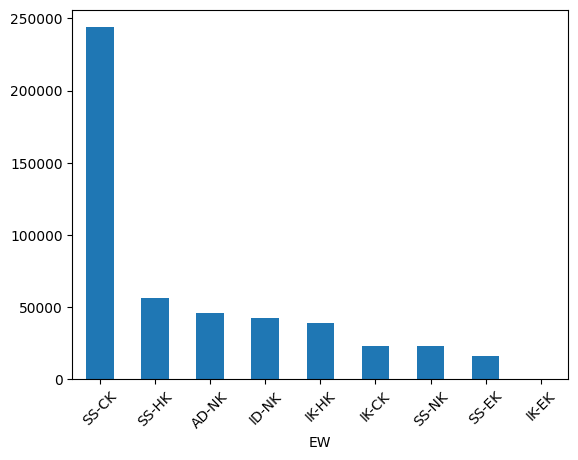

In [55]:
train_data['EW'].value_counts().plot(kind="bar")
plt.xticks(rotation=45)
plt.show()

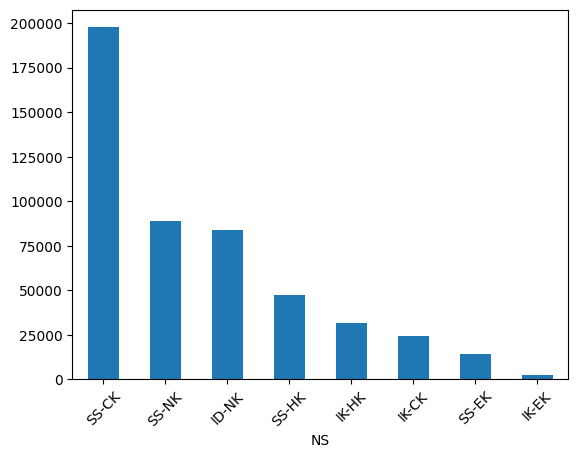

In [56]:
train_data['NS'].value_counts().plot(kind="bar")
plt.xticks(rotation=45)
plt.show()

# Data Preparation

In [10]:
train_data_list = train_data.drop(columns=['ObjectID','TimeIndex']).iloc[:,:-4].values

In [11]:
label_data_EW = train_data.iloc[:,-2].values
label_data_NS = train_data.iloc[:,-1].values

In [12]:
train_data_EW_X, test_data_EW_X, train_data_EW_Y, test_data_EW_Y = train_test_split(train_data_list, label_data_EW, test_size = 0.2,\
                                                                                                   random_state = 123, shuffle = False)
train_data_NS_X, test_data_NS_X, train_data_NS_Y, test_data_NS_Y = train_test_split(train_data_list, label_data_NS, test_size = 0.2,\
                                                                                                   random_state = 123, shuffle = False)

In [13]:
smote = SMOTE()

In [14]:
# balance the dataset
train_data_EW_X_bal, train_data_EW_Y_bal = smote.fit_resample(train_data_EW_X,train_data_EW_Y)
train_data_NS_X_bal, train_data_NS_Y_bal = smote.fit_resample(train_data_NS_X,train_data_NS_Y)

In [15]:
EW_balanced_labels = le_EW.inverse_transform(train_data_EW_Y_bal)
NS_balanced_labels = le_EW.inverse_transform(train_data_NS_Y_bal)

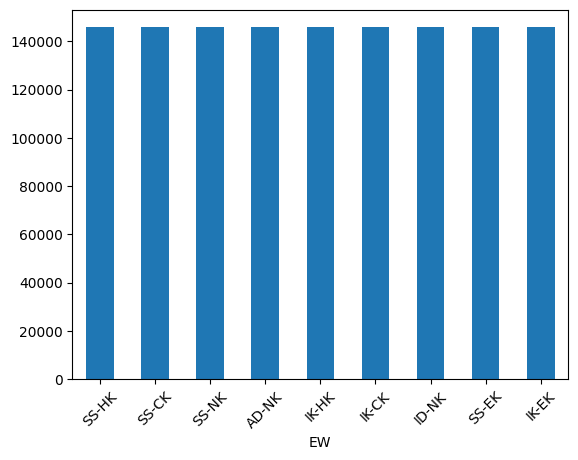

In [16]:
EW_labels = pd.DataFrame()
EW_labels['EW']=EW_balanced_labels
#balanced_labels['NS']=NS_balanced_labels
EW_labels['EW'].value_counts().plot(kind="bar")
plt.xticks(rotation=45)
plt.show()

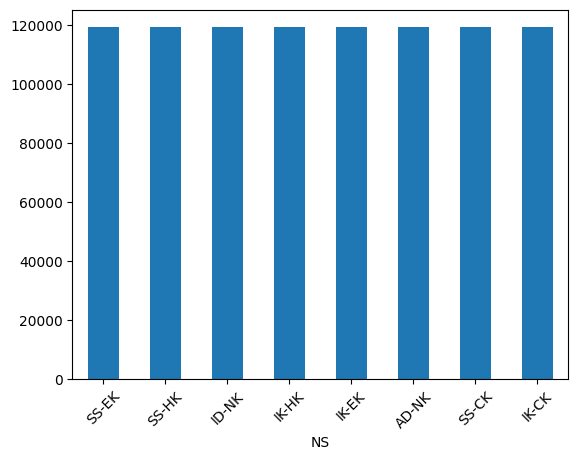

In [17]:
NS_labels = pd.DataFrame()
NS_labels['NS']=NS_balanced_labels
#balanced_labels['NS']=NS_balanced_labels
NS_labels['NS'].value_counts().plot(kind="bar")
plt.xticks(rotation=45)
plt.show()

In [18]:
#initialize StandardScaler
scaler = MinMaxScaler()

In [19]:
# Standardize the data
train_data_EW_X_bal = scaler.fit_transform(train_data_EW_X_bal)
train_data_NS_X_bal = scaler.fit_transform(train_data_NS_X_bal)
test_data_EW_X = scaler.fit_transform(test_data_EW_X)
test_data_NS_X = scaler.fit_transform(test_data_NS_X)

In [20]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [21]:
sequence_length = 1000 # take a month's worth of observations as sequence
feature_length = train_data_EW_X_bal.shape[1] # number of features in the dataset
batch_size = 100

In [22]:
# create LSTM sequences inputs out of given data using keras TimeseriesGenerator module
train_data_X_EW_sequences = TimeseriesGenerator(train_data_EW_X_bal,train_data_EW_Y_bal,length = sequence_length,batch_size=batch_size)
train_data_X_NS_sequences = TimeseriesGenerator(train_data_NS_X_bal,train_data_NS_Y_bal,length = sequence_length,batch_size=batch_size)
test_data_X_EW_sequences = TimeseriesGenerator(test_data_EW_X,test_data_EW_Y,length = sequence_length,batch_size=batch_size)
test_data_X_NS_sequences = TimeseriesGenerator(test_data_NS_X,test_data_NS_Y,length = sequence_length,batch_size=batch_size)

In [20]:
# create LSTM sequences inputs out of given data from my custom function
train_data_X_EW_sequences = utils2.create_sequences(train_data_X_EW_balanced,sequence_length1)
train_data_X_NS_sequences = utils2.create_sequences(train_data_X_NS_balanced,sequence_length2)
train_data_Y_EW_sequences = utils2.create_sequences(train_data_Y_EW_balanced,sequence_length1)
train_data_Y_NS_sequences = utils2.create_sequences(train_data_Y_NS_balanced,sequence_length2)

In [56]:
# Reshape the data for LSTM input (samples, time steps, features)
train_data_X_EW_balanced1 = train_data_X_EW_balanced.reshape((sequence_length1,225,train_data_X_EW_balanced.shape[1]))
train_data_X_NS_balanced1 = train_data_X_NS_balanced.reshape((train_data_X_NS_balanced.shape[0],1,train_data_X_NS_balanced.shape[1]))

ValueError: cannot reshape array of size 197491770 into shape (9753,225,90)

In [23]:
# Build the LSTM model for multi-class classification of EW data
EW_model = Sequential()
EW_model.add(LSTM(50, return_sequences=True,input_shape=(sequence_length,feature_length)))
EW_model.add(Dropout(0.2))
EW_model.add(LSTM(50, return_sequences=False))
EW_model.add(Dropout(0.2))
EW_model.add(Dense(len(EW_labels['EW'].unique()), activation='softmax'))  # Output layer for multi-class classification

In [24]:
# Compile the model
EW_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [63]:
EW_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1000, 50)          28200     
                                                                 
 dropout_4 (Dropout)         (None, 1000, 50)          0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 9)                 459       
                                                                 
Total params: 48859 (190.86 KB)
Trainable params: 48859 (190.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#Train the model
history_EW = EW_model.fit(train_data_X_EW_sequences,validation_data = test_data_X_EW_sequences, epochs=10, shuffle = False)

Epoch 1/10
13106/13106 [==============================] - 3021s 229ms/step - loss: 0.3698 - accuracy: 0.8844 - val_loss: 11.4007 - val_accuracy: 0.0000e+00
Epoch 2/10
13106/13106 [==============================] - 2974s 227ms/step - loss: 0.3776 - accuracy: 0.8856 - val_loss: 14.1928 - val_accuracy: 0.0000e+00
Epoch 3/10
 9017/13106 [===================>..........] - ETA: 15:04 - loss: 0.5064 - accuracy: 0.8418

In [40]:
valid_data_X = valid_data.iloc[:,:-2].values

In [41]:
valid_data_X = scaler.fit_transform(valid_data_X)
valid_data_X = valid_data_X.reshape((valid_data_X.shape[0],1,valid_data_X.shape[1]))

In [42]:
# Make predictions
predictions = EW_model.predict(valid_data_X)

# If it's a classification model, convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)  # For multi-class classification
# For binary classification, you might use a threshold like 0.5 to convert probabilities to 0 or 1

# If you used label encoding, convert the numerical labels back to original labels
predicted_labels = le_EW.inverse_transform(predicted_classes)


1702/1702 [==============================] - 5s 2ms/step


In [43]:
predicted_labels

array(['SS-NK', 'SS-NK', 'SS-NK', ..., 'IK-CK', 'IK-CK', 'SS-NK'],
      dtype=object)

In [44]:
valid_data['Predicted_EW'] = predicted_labels

In [45]:
valid_data.head()

,Eccentricity,Semimajor Axis (m),Inclination (deg),RAAN (deg),Argument of Periapsis (deg),True Anomaly (deg),Latitude (deg),Longitude (deg),Altitude (m),X (m),...,Vy (m/s)_lag_4,Vy (m/s)_lag_5,Vz (m/s)_lag_1,Vz (m/s)_lag_2,Vz (m/s)_lag_3,Vz (m/s)_lag_4,Vz (m/s)_lag_5,EW,NS,Predicted_EW
0,0.000141,4.224428e+07,0.150051,104.366296,48.629370,139.374252,0.025175,-65.223070,3.587068e+07,1.607924e+07,...,1168.669376,1168.669376,-7.965409,-7.965409,-7.965409,-7.965409,-7.965409,SS-NK,SS-NK,SS-NK
1,0.000138,4.224424e+07,0.150422,104.424876,43.956562,173.977589,0.005561,-65.316101,3.587189e+07,3.345573e+07,...,1168.669376,1168.669376,-7.965409,-7.965409,-7.965409,-7.965409,-7.965409,SS-NK,SS-NK,SS-NK
2,0.000148,4.224391e+07,0.150598,104.508808,39.059683,208.779144,-0.015721,-65.409636,3.587126e+07,4.187300e+07,...,1168.669376,1168.669376,-6.359744,-7.965409,-7.965409,-7.965409,-7.965409,SS-NK,SS-NK,SS-NK
3,0.000167,4.224357e+07,0.150618,104.537452,36.298070,241.502804,-0.032891,-65.501081,3.586880e+07,3.907641e+07,...,1168.669376,1168.669376,-3.044640,-6.359744,-7.965409,-7.965409,-7.965409,SS-NK,SS-NK,SS-NK
4,0.000188,4.224362e+07,0.150702,104.473202,34.455987,273.404296,-0.041227,-65.588052,3.586501e+07,2.581318e+07,...,1168.669376,1168.669376,1.097112,-3.044640,-6.359744,-7.965409,-7.965409,SS-NK,SS-NK,SS-NK


In [46]:
# Build the LSTM model for multi-class classification NS
NS_model = Sequential()
NS_model.add(LSTM(50, return_sequences=True,input_shape=(train_data_X_NS_balanced.shape[1], train_data_X_NS_balanced.shape[2])))
NS_model.add(Dropout(0.2))
NS_model.add(LSTM(50, return_sequences=False))
NS_model.add(Dropout(0.2))
NS_model.add(Dense(9, activation='softmax'))  # Output layer for multi-class classificatiNS

In [47]:
# Compile the model
NS_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [48]:
#Train the model
NS_model.fit(train_data_X_NS_balanced, train_data_Y_NS_balanced, epochs=10, batch_size=32,validation_split=0.2)

Epoch 1/10
39536/39536 [==============================] - 185s 5ms/step - loss: 0.2523 - accuracy: 0.9101 - val_loss: 0.5617 - val_accuracy: 0.8609
Epoch 2/10
39536/39536 [==============================] - 184s 5ms/step - loss: 0.1488 - accuracy: 0.9449 - val_loss: 0.5226 - val_accuracy: 0.8814
Epoch 3/10
39536/39536 [==============================] - 181s 5ms/step - loss: 0.1265 - accuracy: 0.9524 - val_loss: 0.5992 - val_accuracy: 0.8820
Epoch 4/10
39536/39536 [==============================] - 182s 5ms/step - loss: 0.1159 - accuracy: 0.9559 - val_loss: 0.6264 - val_accuracy: 0.8869
Epoch 5/10
39536/39536 [==============================] - 176s 4ms/step - loss: 0.1097 - accuracy: 0.9582 - val_loss: 0.6286 - val_accuracy: 0.8907
Epoch 6/10
39536/39536 [==============================] - 177s 4ms/step - loss: 0.1045 - accuracy: 0.9603 - val_loss: 0.6593 - val_accuracy: 0.8901
Epoch 7/10
39536/39536 [==============================] - 174s 4ms/step - loss: 0.1015 - accuracy: 0.9613 - val_

In [49]:
# Make predictions
predictions = NS_model.predict(valid_data_X)

# If it's a classification model, convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)  # For multi-class classification
# For binary classification, you might use a threshold like 0.5 to convert probabilities to 0 or 1

# If you used label encoding, convert the numerical labels back to original labels
predicted_labels = le_NS.inverse_transform(predicted_classes)


1702/1702 [==============================] - 4s 2ms/step


In [50]:
valid_data['Predicted_NS'] = predicted_labels

In [69]:
valid_data = valid_data.drop(columns=['EW_encoded'])

In [51]:
valid_data.head()

,Eccentricity,Semimajor Axis (m),Inclination (deg),RAAN (deg),Argument of Periapsis (deg),True Anomaly (deg),Latitude (deg),Longitude (deg),Altitude (m),X (m),...,Vy (m/s)_lag_5,Vz (m/s)_lag_1,Vz (m/s)_lag_2,Vz (m/s)_lag_3,Vz (m/s)_lag_4,Vz (m/s)_lag_5,EW,NS,Predicted_EW,Predicted_NS
0,0.000141,4.224428e+07,0.150051,104.366296,48.629370,139.374252,0.025175,-65.223070,3.587068e+07,1.607924e+07,...,1168.669376,-7.965409,-7.965409,-7.965409,-7.965409,-7.965409,SS-NK,SS-NK,SS-NK,SS-NK
1,0.000138,4.224424e+07,0.150422,104.424876,43.956562,173.977589,0.005561,-65.316101,3.587189e+07,3.345573e+07,...,1168.669376,-7.965409,-7.965409,-7.965409,-7.965409,-7.965409,SS-NK,SS-NK,SS-NK,SS-NK
2,0.000148,4.224391e+07,0.150598,104.508808,39.059683,208.779144,-0.015721,-65.409636,3.587126e+07,4.187300e+07,...,1168.669376,-6.359744,-7.965409,-7.965409,-7.965409,-7.965409,SS-NK,SS-NK,SS-NK,SS-NK
3,0.000167,4.224357e+07,0.150618,104.537452,36.298070,241.502804,-0.032891,-65.501081,3.586880e+07,3.907641e+07,...,1168.669376,-3.044640,-6.359744,-7.965409,-7.965409,-7.965409,SS-NK,SS-NK,SS-NK,SS-NK
4,0.000188,4.224362e+07,0.150702,104.473202,34.455987,273.404296,-0.041227,-65.588052,3.586501e+07,2.581318e+07,...,1168.669376,1.097112,-3.044640,-6.359744,-7.965409,-7.965409,SS-NK,SS-NK,SS-NK,SS-NK


In [52]:
valid_results = utils.convert_classifier_output(valid_data)
evaluator = evaluation.NodeDetectionEvaluator(ground_truth_valid, valid_results,tolerance=6)
precision, recall, f2, rmse = evaluator.score()
print(f'Precision for the valid set: {precision:.2f}')
print(f'Recall for the valid set: {recall:.2f}')
print(f'F2 for the valid set: {f2:.2f}')
print(f'RMSE for the valid set: {rmse:.2f}')

Precision for the valid set: 0.00
Recall for the valid set: 0.74
F2 for the valid set: 0.01
RMSE for the valid set: 1.54


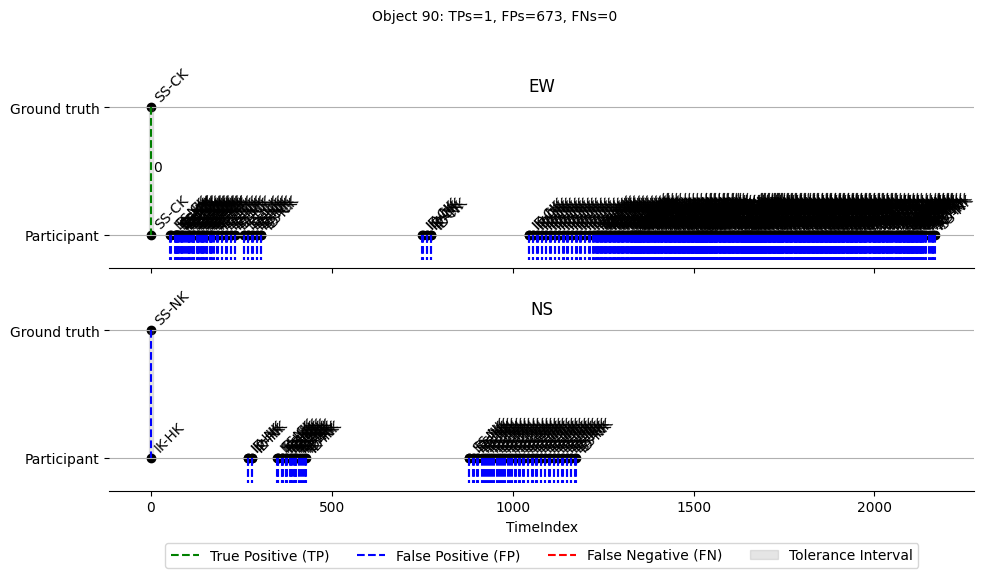

In [56]:
# Plot the evaluation timeline for a random ObjectID from the validation set
evaluator.plot(np.random.choice(valid_data['ObjectID'].unique()))

In [57]:
# Loop over the Object IDs in the training set and call the evaluation
# function for each object and aggregate the results
total_tp = 0
total_fp = 0
total_fn = 0
for oid in valid_data['ObjectID'].unique():
    tp, fp, fn, gt_object, p_object = evaluator.evaluate(oid)
    total_tp += tp
    total_fp += fp
    total_fn += fn

print(f'Total true positives: {total_tp}')
print(f'Total false positives: {total_fp}')
print(f'Total false negatives: {total_fn}')

Total true positives: 29
Total false positives: 15439
Total false negatives: 10


In [59]:
# Save the trained random forest models (and label encoders) to disk
# Create the folder trained_model if it doesn't exist
Path('trained_model').mkdir(exist_ok=True)
pickle.dump(EW_model, open('trained_model/model_EW_LSTM_smote.pkl', 'wb'))
pickle.dump(NS_model, open('trained_model/model_NS_LSTM_smote.pkl', 'wb'))
pickle.dump(le_EW, open('trained_model/le_EW.pkl', 'wb'))
pickle.dump(le_NS, open('trained_model/le_NS.pkl', 'wb'))

# Saved Model Inference section

In [15]:
import pickle

In [16]:
config.challenge_data_dir

Path('D:/SPLID/splid-devkit/data')

In [25]:
EW_model_file_path = Path('D:/SPLID/splid-devkit/baseline_submissions/ml_python/ML_solutions/trained_model/LSTM_model_EW.pkl')

In [26]:
with model_file_path.open("rb") as f:
    EW_model = pickle.load(f)

f.close()

PermissionError: [Errno 13] Permission denied: 'D:\\SPLID\\splid-devkit\\baseline_submissions\\ml_python\\ML_solutions\\trained_model'